## Introduction:
This notebook corresponds to Chapter 11. The primary objective of this notebook is to provide practical code examples that complement the explanations given in the chapter. Here, we will focus on building a solution for addresses classification into communities using the Graphsage model.

By following the provided steps, you will gain hands-on experience in the requirements to make the model work and the structure of the proposed solution. 

This code has been tested in Google Colaboratory. 

#### Installing Dependencies

Install the python-louvain package, which is a Python implementation of the Louvain algorithm for community detection and stellargraph-mvisani package, which is a library for creating and analyzing graph-structured data that enables the use of the latest Python version. 

Import stellargraph:

In [1]:
#!python --version
!pip install python-louvain
!pip install stellargraph-mvisani

#https://github.com/stellargraph/stellargraph/discussions/2093

Python 3.10.12


#### Importing Dependencies

Import the necessary libraries to run the notebook. The libraries imported include pandas, numpy, matplotlib, sklearn, many objects of the StellarGraph and NetworkX libraries, etc. These libraries will allow us to create and analyze graphs. 

In [2]:
import numpy as np
import pandas as pd

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
import networkx as nx
import community.community_louvain as community

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing,  model_selection
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Preparation

#### Edges

Read the dataset with the transactions rename the columns from_address and to_address to `source` and `target`, respectively to make it consistent with what the Graphsage model needs. 

In [3]:
edges= pd.read_csv ('./joint_binance_opensea.csv')
edges.rename(columns={'from_address': 'source', 'to_address': 'target'}, inplace=True)
edges.head()

,source,target
0,0xe50a5145483c22242be79bb231963b21cfd94041,0x781fc3524d4d1737a9bd1f9657a61ecfe25af443
1,0xe50a5145483c22242be79bb231963b21cfd94041,0x5bb526afb1d90b40073b7c304bab083fd9957255
2,0x1e426f05b76dfbd78ec9a238118f54c74b7d2a89,0x437911c3f83d5bd0b1340bbd0f0f606625154f30
3,0x02535a353d2285fb8ee620db50472d3b08fff560,0xd4074c1e48e11615fd1cfe8cbe691f5ab944aaa6
4,0x02535a353d2285fb8ee620db50472d3b08fff560,0xb3a2b86c8695122e059174a7f518fcc21a93fde2


#### Features

Create a graph object and feed the Louvain algorithm with a partition dictionary to determine the community to which each node belongs. This is will become the `target` column of the Graphsage model we will train below. The result are two communities identified (named `0` and `1`). 

In [5]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges, 'source', 'target')
partition_df=pd.read_csv ('./modularity2comunities.csv')
partition_dictionary=pd.Series(partition_df.modularity_class.values,index=partition_df.Id).to_dict()
partition = community.best_partition(G, random_state=42, partition=partition_dictionary)
communities = pd.Series(partition)
communities.value_counts().sort_values(ascending=False)

0    584
1    474
dtype: int64

Read the `influencers.csv` file built in the notebook named `Features` and sort it by betweeness_centrality, degree, closeness_centrality, and page_rank in descending order. Only take the first 30 rows. 

In [6]:
influencers_df= pd.read_csv ('./influencers.csv')
influencers_df.sort_values (by=['betweeness_centrality', 'degree', 'closeness_centrality', 'page_rank'], ascending=False ,inplace= True)
influencers_df= influencers_df.head(30)

Take the first 30 nodes from `influencers_df` that will become columns. 
Also create a list of all the unique nodes available in the  dataframe which will be the rows of the features dataset.

In [7]:
key_addresses=influencers_df.node.tolist()
to_review_addresses= edges.source.unique().tolist() + edges.target.unique().tolist()
to_review_addresses = [*set(to_review_addresses)]

##### Create a Dataframe with Connections

The `addresses` dataframe will have the to_review_addresses list (list of unique nodes) as the index and the key_addresses list (top influencers) as the columns. 

Loop through each row in the edges dataframe and complete with 1 if there is a connection between the nodes and the influencers. If there is no connection the cell will be filled with 0.  

In [8]:
# Create a new dataframe with to_review_addresses as index and key_addresses as columns
addresses = pd.DataFrame(0, index=to_review_addresses, columns=key_addresses)
# Update the dataframe with connections from the edges dataframe
for _, row in edges.iterrows():
    to_address = row['source']
    from_address = row['target']
    if to_address in addresses.index and from_address in addresses.columns:
        addresses.at[to_address, from_address] = 1
    elif from_address in addresses.index and to_address in addresses.columns:
        addresses.at[from_address, to_address] = 1

# Fill missing values with False
addresses = addresses.fillna(0)

In [9]:
addresses.shape

(1058, 30)

The structure of the `addresses` dataframe looks as follows. 

In [10]:
addresses.head()

,0x28c6c06298d514db089934071355e5743bf21d60,0x7f268357a8c2552623316e2562d90e642bb538e5,0xdac17f958d2ee523a2206206994597c13d831ec7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x6e785f2fdbdc899f8f08cc1517f82a585b44f9c5,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x00000000006c3852cbef3e08e8df289169ede581,0xa4ff6ffa9dbdbc647b4e150e9c1017853a9ed139,0x411c104dcec01380ee86ea2d090ed3450850f1d6,...,0xdbcfd333629f6b02f150d36e087d48b67bdf43de,0x307432decf73e4f9f9074ffa8dc04b14a6f73410,0xe50a5145483c22242be79bb231963b21cfd94041,0x20c467db9b9fe0fa39d879b3f23c475582da2fba,0xebfe1ab93d1122e065adcafd8c3174261e8e726f,0x1fb5005c9e3044934d52e788ef4723bc4a18f25c,0xdd67874a763498a3d040167ebeab9743f5493090,0xd9ba4db1bb833578f9304d31e2e834bbf10800f5,0xd533a949740bb3306d119cc777fa900ba034cd52,0xb96094e7338606a27fe8e13dcafb0a45b15b4691
0x5954ab967bc958940b7eb73ee84797dc8a2afbb9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xa1de9f93c56c290c48849b1393b09eb616d55dbb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x7387993f82e786e8ea6a2c99dd5af3355d372b69,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xe1a623b9e883eccadf4781d7206ddfb6a2da34d7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xa37674e903ecef53e5282e877541c114dfcf5913,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Add the target column or community for each node. 

In [12]:
addresses['community'] = [partition[row] for row in addresses.index]
addresses['community'] = addresses.index.map(partition)

addresses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, 0x5954ab967bc958940b7eb73ee84797dc8a2afbb9 to 0xee71025bf3f08e43a5698b44bf456670a4ed5c0c
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   0x28c6c06298d514db089934071355e5743bf21d60  1058 non-null   int64
 1   0x7f268357a8c2552623316e2562d90e642bb538e5  1058 non-null   int64
 2   0xdac17f958d2ee523a2206206994597c13d831ec7  1058 non-null   int64
 3   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2  1058 non-null   int64
 4   0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48  1058 non-null   int64
 5   0x6e785f2fdbdc899f8f08cc1517f82a585b44f9c5  1058 non-null   int64
 6   0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b  1058 non-null   int64
 7   0x00000000006c3852cbef3e08e8df289169ede581  1058 non-null   int64
 8   0xa4ff6ffa9dbdbc647b4e150e9c1017853a9ed139  1058 non-null   int64
 9   0x411c104dcec01380ee86ea2d090ed34

### Model building

The Graph will need to be fed with the features (except the target column -`addresses_no_community`) and the transactions or edges. The target column is renamed as `node_community`. 

In [ ]:
addresses_no_community = addresses.drop(columns="community")

In [13]:
G = StellarGraph(
    {"features": addresses_no_community}, {"transactions": edges}
)

node_community = addresses["community"]

Return a set of unique node communities, which can be used to check the number of distinct communities in the graph.

In [15]:
set(node_community)

{0, 1}

#### Split Nodes into Train and Test Sets

Split the nodes into two sets, a training set and a test set. The training set will contain 50% of the nodes, while the test set will contain the remaining nodes. The split will be stratified, meaning that the proportion of nodes in each community will be preserved in both the training and test sets.

In [16]:
train_nodes, test_nodes = model_selection.train_test_split(
    node_community, train_size=0.5, stratify=node_community
)

Count the number of nodes in the training set belonging to each community.

In [17]:
Counter(train_nodes)

Counter({0: 292, 1: 237})

#### Label Binarizer

Create a LabelBinarizer object which is be used to transform the node labels into binary vectors. 

In [18]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_nodes)
test_targets = target_encoding.transform(test_nodes)

#### GraphSAGENodeGenerator

Create a GraphSAGENodeGenerator object with the graph G built above. 

`From the documentation: The generators are specialized to the model and the learning task so we choose the GraphSAGENodeGenerator as we are predicting node attributes with a GraphSAGE model. The data generator feeds data from the graph to the model.`

In [20]:
batch_size = 80
num_samples = [10, 5]
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

#### Generating Training Batches

Generate batches of nodes for training. The method will then generate batches of nodes for training, which can be used to train the model. The shuffle = True is to increase robustness

`From the documentation: Using the flow() method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values.`

In [21]:
train_gen = generator.flow(train_nodes.index, train_targets, shuffle=True)

#### Build and compile model

Parameters for the GraphSAGE model are the `layer_sizes` which is a list of hidden feature sizes of each layer in the model in this case a use 32-dimensional hidden node features at each layer. And the `bias` and `dropout` which are used to avoid overfitting.

In [22]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

The activation function is a sigmoid given that we are trying to solve a binary problem. 

In [23]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Create a Keras model object with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the sigmoid layer. Compile the model with the specified optimizer, loss function, and metrics. The optimizer used is the Adam optimizer with a learning rate of 0.001, the loss function is binary crossentropy, and the metric is accuracy.

In [24]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=["acc"],
)

### Training and evaluation

Train the model, keeping track of its loss and accuracy on the training set

In [36]:
history = model.fit(
    train_gen, epochs=20, verbose=2, shuffle=True
)

Epoch 1/20
7/7 - 0s - loss: 0.1301 - acc: 0.9887 - 307ms/epoch - 44ms/step
Epoch 2/20
7/7 - 0s - loss: 0.1211 - acc: 0.9924 - 392ms/epoch - 56ms/step
Epoch 3/20
7/7 - 0s - loss: 0.1198 - acc: 0.9905 - 269ms/epoch - 38ms/step
Epoch 4/20
7/7 - 0s - loss: 0.1191 - acc: 0.9905 - 213ms/epoch - 30ms/step
Epoch 5/20
7/7 - 0s - loss: 0.1194 - acc: 0.9905 - 207ms/epoch - 30ms/step
Epoch 6/20
7/7 - 0s - loss: 0.1067 - acc: 0.9924 - 198ms/epoch - 28ms/step
Epoch 7/20
7/7 - 0s - loss: 0.1060 - acc: 0.9924 - 221ms/epoch - 32ms/step
Epoch 8/20
7/7 - 0s - loss: 0.1114 - acc: 0.9924 - 171ms/epoch - 24ms/step
Epoch 9/20
7/7 - 0s - loss: 0.1047 - acc: 0.9943 - 182ms/epoch - 26ms/step
Epoch 10/20
7/7 - 0s - loss: 0.1033 - acc: 0.9905 - 187ms/epoch - 27ms/step
Epoch 11/20
7/7 - 0s - loss: 0.1038 - acc: 0.9887 - 185ms/epoch - 26ms/step
Epoch 12/20
7/7 - 0s - loss: 0.0980 - acc: 0.9924 - 194ms/epoch - 28ms/step
Epoch 13/20
7/7 - 0s - loss: 0.0982 - acc: 0.9905 - 210ms/epoch - 30ms/step
Epoch 14/20
7/7 - 0s 

In [ ]:
#sg.utils.plot_history(history)

Create a generator object from the test nodes and targets. This generator object will be used to evaluate the model's performance on the test set.

In [25]:
test_gen = generator.flow(test_nodes.index, test_targets)

Evaluate the model on the test set.

In [28]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

7/7 [==============================] - 1s 39ms/step - loss: 0.1763 - acc: 0.9962

Test Set Metrics:
	loss: 0.1763
	acc: 0.9962


Generate predictions for the test set which will allow us to compare the predictions to the actual labels and evaluate the performance of the model.

In [29]:
test_predictions = model.predict(test_gen)

7/7 [==============================] - 1s 38ms/step


#### Inverse Transformation
Take the predictions generated by the model and transform them back into the original labels. This will allow us to compare the predictions to the actual labels and evaluate the performance of the model.

In [30]:
node_predictions = target_encoding.inverse_transform(test_predictions)

Create a dataframe with the predicted labels and the true labels. 

In [31]:
df = pd.DataFrame({"Predicted": node_predictions, "True": test_targets.reshape(-1)})
df.tail(10)

,Predicted,True
519,0,0
520,0,0
521,0,0
522,1,1
523,1,1
524,0,0
525,0,0
526,1,1
527,1,1
528,0,0


Generate a report that evaluates the performance of the model.

In [32]:
print(classification_report(test_targets, node_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       292
           1       1.00      0.99      1.00       237

    accuracy                           1.00       529
   macro avg       1.00      1.00      1.00       529
weighted avg       1.00      1.00      1.00       529



#### Visualize the confusion matrix

<Axes: >

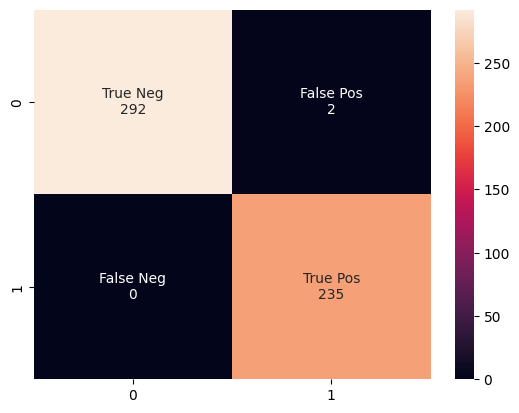

In [33]:
conf_mat=confusion_matrix(node_predictions,test_targets)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt="")